<h3> NBA 5 year careeer prediction using XBoost Classifier

In [1]:
import pandas as pd
import numpy as np

<h4> 1. Load processed sets

<h5> Loading scaled training, validation and test sets from data_prep step saved on the data/processed folder saving them into X_train, X_val, y_train, y_val, X_test, X_test_ID variables

In [2]:
#Load Test and validation sets using custom function load_sets
from src.data.sets import load_sets

In [3]:
X_train, X_val, y_train, y_val, X_test, X_test_ID = load_sets()

<h4> 2. Import Random Forest

<h5> Importing and fitting Random Forest Classifier with 300 estimators

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
# calculating weights for unbalanced data validation
sum_wpos = len([item for item in y_train if item==1 ])
sum_wneg = len([item for item in y_train if item==0 ])
sum_wneg/sum_wpos

1.0

<h5> We can see that the trainins get after samlping is evenly distributed between classes

<h4> 2.1 Analyse features importance in random forest model with current training sets

<h5> Random Search of parameters usin cross validation

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
#Generating a Random grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [ ]:
rf_random.best_params_

In [6]:
rf_model = RandomForestClassifier(n_estimators = 300, random_state=44, 
                                  max_depth = 5 )

In [7]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(rf_model
                     # , threshold = "0.98*mean"
                     )
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(max_depth=6, n_estimators=300,
                                                 random_state=44))

<h4> 2.2 Finding the most relevant features in making predictions

<h5> After the model has been fitted, we use get.support to find out which features are most relevant in the predictions

In [8]:
columns = sel.get_support()
columns = columns.tolist()

<h5> As column importance is given in order of appearance on the scaled set, importing column names saved in data_prep for easy visualization and identification will be performed

<h5> Importing predictor column names and combining with relevant columns to find out the best feature predictors

In [9]:
predictors  = pd.read_csv('../data/interim/predictor_names.csv')

In [10]:
predictors_df = predictors.copy()

In [11]:
predictors = predictors['names'].tolist()

In [12]:
predictors_df['Relevant_Feature'] = columns

In [13]:
#print(predictors_df.loc[predictors_df['Relevant_Feature'] == 1])

<h5> <b>CONCLUSION ON PREDICTORS: </b> Based on the rebalanced training set from data_prep, 6 features are the most relevant predictors. Therefore new data prep will be generated for usage of these columns within the model

<h4> 3 Train RF Classifier with new calculated training sets

<h5> Next up, the RF classifier will be imported and trained with the new training set and saved into the models folder

In [14]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=300, random_state=44)

<h5> After the model has been fitted, it will be saved in the models folder in case it needs to be re-called on a later process

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
#Save model in the models folder
#from joblib import dump
#dump(rf_model, '../models/RF3.joblib')

<h4> 3.1 Generate predictions for training and validation sets in order to compare accuracy vs Baseline

<h5> The fitted model will be used to predict the validation set and accuracy willl be calculated to compare vs the baseline

In [17]:
y_val_preds = rf_model.predict(X_val)

In [18]:
y_trainpreds = rf_model.predict(X_train)

<h4> 3.2 Calculate mse and mae to assess fiting accuracy for the training and validation sets

In [19]:
#Get error/score metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [20]:
rf_model.score(X_train, y_train)

0.7550140581068416

In [21]:
rf_model.score(X_val, y_val)

0.66

<h5> The training model shows a perfect fit, however the model score drops to 0.80 on the validation set

<h4> 3 Analysis of the validation set

<h5> Analysis of the results will be done through a confusion matrix to gather insights as to where the accuracy/innacuracy exists in order to improve the model in future experiments <br> <br> We'll look into a confusion matrix to see the distribution of the predictions from the model

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

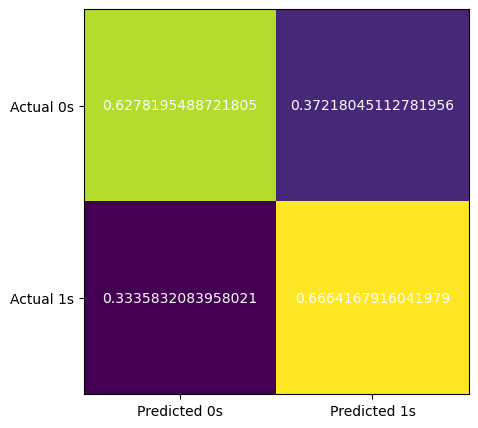

In [23]:
cm = confusion_matrix(y_val, y_val_preds , normalize='true'
                     )

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

<h5> As seen in the confusion matrix, 92% of true positive target was predicted correctly, however, 81% of negative target was predicted incorrectly (false positive)

In [24]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [25]:
y_val_prob = rf_model.predict_proba(X_val)

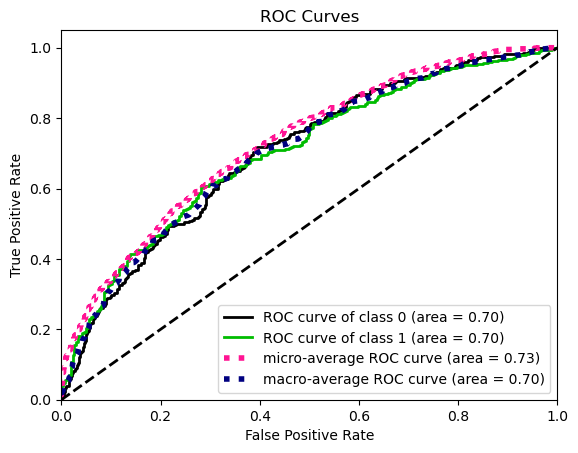

In [26]:
skplt.metrics.plot_roc(y_val, y_val_prob)
plt.show()

<h5> When analysing the results on the validation set, the mean ROC AUC is 0.68, meaning the model is predicting only 69% of the instances correctly

<h5> Analysing true positives vs false positives as this is where the model is not accurately predicting the target

In [27]:
X_val_df = pd. DataFrame(X_val, columns = predictors)

In [28]:
y_val_list = y_val.tolist()
X_val_df['y_val']=y_val_list

In [29]:
X_val_df['y_val_preds']=y_val_preds

In [30]:
#True Negatives
X_val_true_neg = X_val_df[(X_val_df['y_val']==0)&(X_val_df['y_val_preds']==0)]
X_val_true_neg.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,3P_per_GP,Stl_per_GP,ORtg,PPP,TSP,Reb_per_GP,Min_per_GP,Blk_per_GP,y_val,y_val_preds
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,...,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,167.0
mean,45.880240,11.489820,3.852695,1.474850,3.741916,40.178443,0.271856,0.837126,22.165868,0.697006,...,0.006176,0.010333,77.455523,0.774555,0.463609,0.037212,0.266699,0.002877,0.0,0.0
std,13.537455,4.868062,1.973768,0.759971,1.992587,5.543814,0.291834,0.850973,15.941266,0.456338,...,0.007338,0.006775,10.837586,0.108376,0.054064,0.023365,0.127116,0.003590,0.0,0.0
min,4.000000,2.900000,0.800000,0.300000,0.800000,27.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001852,44.426494,0.444265,0.333333,0.006383,0.082979,0.000000,0.0,0.0
25%,37.500000,7.900000,2.450000,0.900000,2.200000,36.600000,0.000000,0.000000,9.400000,0.400000,...,0.000000,0.005128,70.639414,0.706394,0.427958,0.021320,0.188105,0.000000,0.0,0.0
50%,47.000000,11.000000,3.600000,1.400000,3.300000,39.800000,0.200000,0.700000,20.900000,0.600000,...,0.004762,0.009302,76.871658,0.768717,0.460025,0.030645,0.242188,0.001887,0.0,0.0
75%,54.000000,14.200000,5.100000,1.900000,4.800000,43.250000,0.500000,1.300000,32.300000,0.900000,...,0.009347,0.013333,82.314920,0.823149,0.489149,0.047673,0.313837,0.005196,0.0,0.0
max,80.000000,26.000000,10.400000,4.000000,10.500000,58.100000,1.400000,3.900000,73.700000,2.900000,...,0.038462,0.043750,128.406709,1.284067,0.717213,0.118750,0.950000,0.025000,0.0,0.0


In [31]:
X_val_true_neg.shape

(167, 29)

In [32]:
#False Positive
X_val_false_pos = X_val_df[(X_val_df['y_val']==0)&(X_val_df['y_val_preds']==1)]
X_val_false_pos.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,3P_per_GP,Stl_per_GP,ORtg,PPP,TSP,Reb_per_GP,Min_per_GP,Blk_per_GP,y_val,y_val_preds
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0,99.0
mean,64.717172,19.241414,7.709091,2.977778,6.587879,45.284848,0.367677,1.072727,22.614141,1.441414,...,0.005887,0.009862,88.207685,0.882077,0.519501,0.058541,0.303842,0.006626,0.0,1.0
std,13.343989,6.277869,2.805246,1.116075,2.520782,5.098126,0.257471,0.728266,15.538905,0.708262,...,0.004244,0.005396,9.291536,0.092915,0.046577,0.033848,0.098684,0.012710,0.0,0.0
min,27.000000,10.100000,2.700000,1.100000,2.300000,31.200000,0.000000,0.000000,0.000000,0.300000,...,0.000000,0.000000,62.682216,0.626822,0.386691,0.006154,0.142222,0.000000,0.0,1.0
25%,56.000000,15.050000,5.600000,2.100000,4.650000,42.450000,0.200000,0.500000,11.300000,0.900000,...,0.002941,0.005848,82.813103,0.828131,0.492884,0.034471,0.235208,0.001575,0.0,1.0
50%,65.000000,18.300000,6.900000,2.700000,6.300000,45.000000,0.400000,1.100000,21.600000,1.200000,...,0.005455,0.009722,88.674549,0.886745,0.521807,0.054118,0.289231,0.003896,0.0,1.0
75%,73.000000,22.850000,9.650000,3.700000,8.000000,48.250000,0.500000,1.450000,31.300000,1.900000,...,0.008631,0.012500,94.199881,0.941999,0.543382,0.075523,0.357576,0.007418,0.0,1.0
max,93.000000,38.100000,15.800000,6.200000,14.800000,57.700000,1.100000,3.200000,72.800000,4.200000,...,0.019298,0.031034,119.132290,1.191323,0.653786,0.186842,0.656897,0.118182,0.0,1.0


In [33]:
X_val_false_pos.shape

(99, 29)

In [34]:
# True Positives
X_val_true_pos = X_val_df[(X_val_df['y_val']==1)&(X_val_df['y_val_preds']==1)]
X_val_true_pos.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,3P_per_GP,Stl_per_GP,ORtg,PPP,TSP,Reb_per_GP,Min_per_GP,Blk_per_GP,y_val,y_val_preds
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.00000,889.000000,889.000000,889.000000,...,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.0,889.0
mean,71.776153,22.243082,9.086839,3.517548,7.575703,46.746232,0.34027,0.997863,20.298988,1.773678,...,0.004817,0.010907,89.225066,0.892251,0.526623,0.057646,0.312556,0.005986,1.0,1.0
std,13.794194,8.758475,4.263116,1.689330,3.650817,5.723977,0.30734,0.877641,14.416332,0.908025,...,0.004420,0.005902,9.145007,0.091450,0.047691,0.029129,0.111569,0.011153,0.0,0.0
min,33.000000,6.900000,1.700000,0.700000,1.500000,28.500000,0.00000,0.000000,0.000000,0.200000,...,0.000000,0.000000,65.309842,0.653098,0.396310,0.007143,0.089610,0.000000,1.0,1.0
25%,62.000000,15.500000,6.000000,2.300000,4.900000,43.000000,0.00000,0.200000,8.700000,1.100000,...,0.000000,0.006849,83.001328,0.830013,0.495536,0.035821,0.230667,0.002247,1.0,1.0
50%,71.000000,20.500000,8.100000,3.100000,6.700000,46.500000,0.30000,0.900000,19.100000,1.600000,...,0.004301,0.009756,88.552916,0.885529,0.522629,0.053125,0.297872,0.004000,1.0,1.0
75%,81.000000,27.500000,11.500000,4.400000,9.600000,50.500000,0.50000,1.600000,30.000000,2.300000,...,0.007576,0.013580,94.488189,0.944882,0.554623,0.073134,0.375472,0.006667,1.0,1.0
max,115.000000,59.400000,30.300000,12.000000,28.600000,63.600000,1.60000,4.400000,72.300000,7.000000,...,0.027027,0.044444,130.813953,1.308140,0.724249,0.257576,0.962162,0.225000,1.0,1.0


In [35]:
X_val_true_pos.shape

(889, 29)

In [36]:
# False Negative
X_val_false_neg = X_val_df[(X_val_df['y_val']==1)&(X_val_df['y_val_preds']==0)]
X_val_false_neg.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,3P_per_GP,Stl_per_GP,ORtg,PPP,TSP,Reb_per_GP,Min_per_GP,Blk_per_GP,y_val,y_val_preds
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,...,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.0
mean,49.406742,12.677079,4.243820,1.617528,3.974607,41.345393,0.294607,0.895955,20.983820,0.793034,...,0.006228,0.009693,80.131602,0.801316,0.476081,0.040269,0.265530,0.003540,1.0,0.0
std,11.415315,5.163233,2.118545,0.800314,2.028381,5.490229,0.305162,0.878949,14.712447,0.484602,...,0.006809,0.006029,10.586905,0.105869,0.053492,0.023809,0.107420,0.005261,0.0,0.0
min,10.000000,4.000000,1.000000,0.400000,1.100000,27.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,54.207537,0.542075,0.355450,0.007500,0.085106,0.000000,1.0,0.0
25%,43.000000,9.300000,2.800000,1.100000,2.500000,37.500000,0.000000,0.000000,8.300000,0.400000,...,0.000000,0.005263,73.099415,0.730994,0.440379,0.025000,0.185106,0.000000,1.0,0.0
50%,50.000000,11.700000,3.900000,1.500000,3.500000,40.900000,0.200000,0.700000,19.500000,0.700000,...,0.004545,0.008163,79.011345,0.790113,0.469005,0.034694,0.241463,0.002273,1.0,0.0
75%,58.000000,15.000000,5.200000,2.000000,4.800000,44.800000,0.500000,1.500000,32.500000,1.000000,...,0.010000,0.013208,87.101557,0.871016,0.510899,0.050000,0.328814,0.005085,1.0,0.0
max,81.000000,37.900000,12.700000,5.100000,12.500000,57.500000,1.700000,4.700000,62.600000,2.700000,...,0.050000,0.035897,118.938701,1.189387,0.689290,0.168293,0.634483,0.073913,1.0,0.0


In [37]:
X_val_false_neg.shape

(445, 29)

<h4> 4 Generate predictions on the test set for Kaggle submission

<h5> The final step is to generate the prediction probabilities from the test set in order to evaluate the score from Kaggle via csv upload

In [38]:
y_test_preds = rf_model.predict_proba(X_test)

In [39]:
#Create Data Frame for Doc printing
df =pd.DataFrame()

In [40]:
y_test_preds

array([[0.61376641, 0.38623359],
       [0.56787672, 0.43212328],
       [0.25798781, 0.74201219],
       ...,
       [0.66087353, 0.33912647],
       [0.22229296, 0.77770704],
       [0.53605676, 0.46394324]])

In [41]:
target_prob = y_test_preds
target_prob = [item[1] for item in y_test_preds]

In [42]:
df['Id'] = X_test_ID
df['TARGET_5Yrs'] = target_prob

In [43]:
df.head()

,Id,TARGET_5Yrs
0,0,0.386234
1,1,0.432123
2,2,0.742012
3,3,0.789388
4,4,0.506371


In [44]:
#Saving predictions into csv
df.to_csv('../data/external/Kaggle_submission_RF_ncr_all_cols.csv', index=False)